# Attention in Neural Machine Translation

## Introduction: Sequence to Sequence Model (LSTM)

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) (now a days replaced by Transformers) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector* (not conext vector from attention). We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

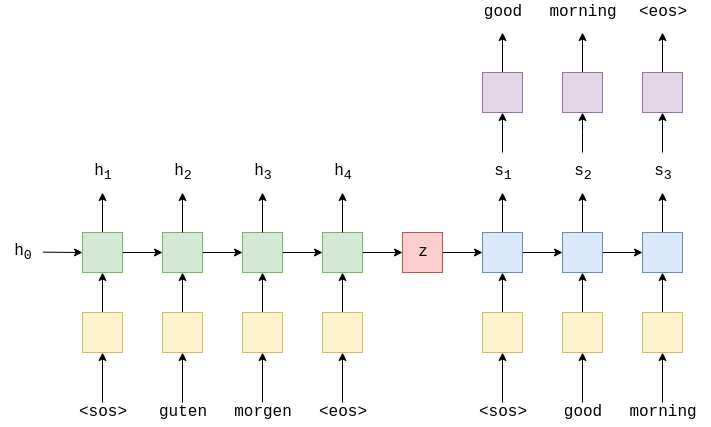)

The above image shows an example translation. The input/source sentence, "guten morgen", is passed through the embedding layer (yellow) and then input into the encoder (green). We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the embedding, $e$, of the current word, $e(x_t)$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. We can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $e(x_t)$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). 

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN via the embedding layer, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the output/target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the embedding, $d$, of current word, $d(y_t)$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

Although the input/source embedding layer, $e$, and the output/target embedding layer, $d$, are both shown in yellow in the diagram they are two different embedding layers with their own parameters.

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called *teacher forcing*, see a bit more info about it [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.

## Introduction: Multi Layer Sequence to Sequence Model (GRU)

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. By alleviating some of this information compression, we can create a better model!

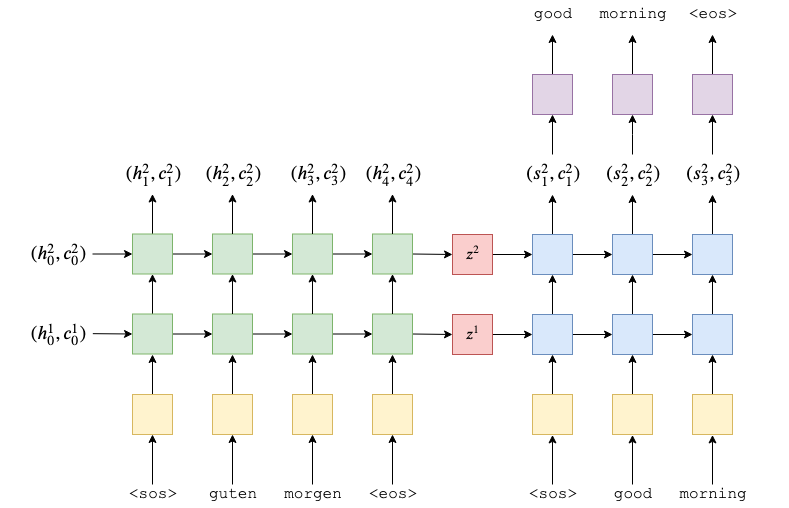

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). Why? To understand how GRUs (and LSTMs) differ from standard RNNS, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) link. Is a GRU better than an LSTM? [Research](https://arxiv.org/abs/1412.3555) has shown they're pretty much the same, and both are better than standard RNNs.


## Intorduction: Sequence to Sequence Model with Attention
In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

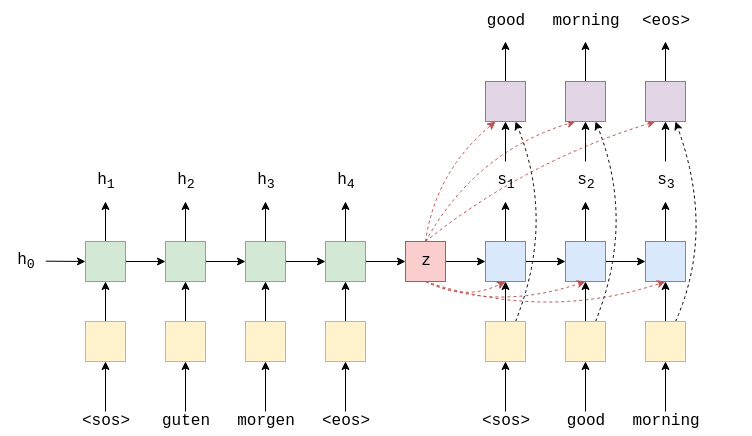

**Bottleneck Problem :** Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

Refernce Paper: [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
Refence Codebase: [PyTorch Seq2Seq](https://github.com/bentrevett/pytorch-seq2seq)


We'll be coding up the models in PyTorch and using torchtext to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data.

In [14]:
import torch                                # importing torch
import torch.nn as nn                       # importing layer
import torch.optim as optim                 # importing optimizer
import torch.nn.functional as F             # importing functions -Functional interface

from torchtext.legacy.datasets import Multi30k                  #The small-dataset WMT 2016 multimodal task, also known as Flickr30k
from torchtext.legacy.data import Field                         #Defines a datatype together with instructions for converting to Tensor.
from torchtext.legacy.data import BucketIterator                #Defines an iterator that batches examples of similar lengths together.

import numpy as np

import random
import math
import time

In [15]:
#Set the random seeds for reproducability.
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word. 

spaCy has model for each language ("de_core_news_sm" for German and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model. 

**Note**: the models must first be downloaded using the following on the command line: 

In [16]:
#spaCy has model for each language ("de_core_news_sm" for German and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model.
#Note: the models must first be downloaded using the following on the command line:

!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download de_core_news_sm -q

2021-04-10 11:36:31.051322: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-04-10 11:36:36.551276: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


We load the models as such:

In [17]:
#Load the German and English spaCy models.
import spacy
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

Next, we create the tokenizer functions. These can be passed to torchtext and will take in the sentence as a string and return the sentence as a list of tokens.

In [18]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Torchtext's `Field`s handle how data should be processed. All of the possible arguments are detailed [here](https://torchtext.readthedocs.io/en/latest/data.html#field). 

We set the `tokenize` argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The field also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

In [19]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Next, we download and load the train, validation and test data. 

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence. 

`exts` specifies which languages to use as the source and target (source goes first) and `fields` specifies which field to use for the source and target.

In [20]:
#Load the data.
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

We can double check that we've loaded the right number of examples:

In [21]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


We can also print out an example, making sure the source sentence is reversed:

In [22]:
print(vars(train_data.examples[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


Next, we'll build the *vocabulary* for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

In [23]:
#Build the vocabulary.
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [24]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary. 

We also need to define a `torch.device`. This is used to tell torchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, torchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
#Create the iterators.
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. We use a single layer BiGRU (a *bidirectional RNN*). With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN. 

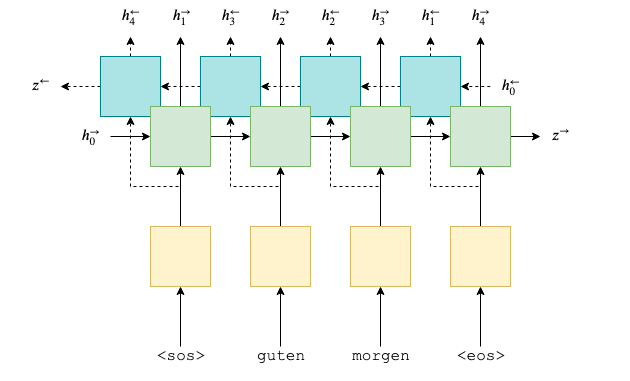

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

We only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

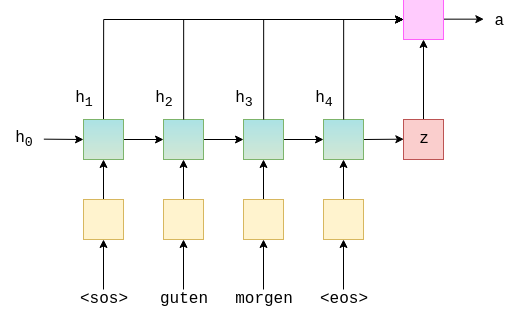

In [28]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

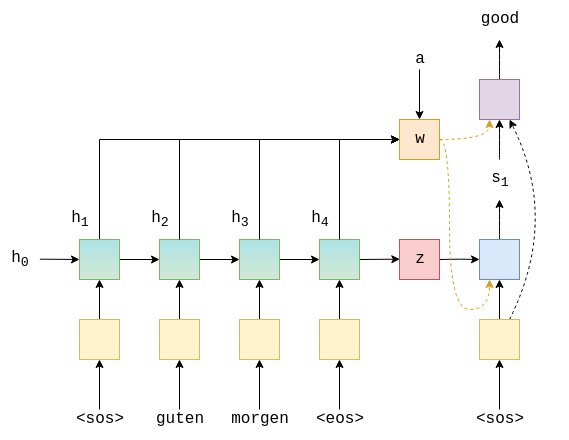

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle: 
- receiving the input/source sentence
- using the encoder to produce the context vectors and attention 
- using the decoder to produce the predicted output/target sentence

**Decision:** if we did something like having a different number of layers then we would need to make decisions about how this is handled. For example, if our encoder has 2 layers and our decoder only has 1, how is this handled? Do we average the two context vectors output by the decoder? Do we pass both through a linear layer? Do we only use the context vector from the highest layer? Etc.

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio (internally compute attention). The `teacher forcing ratio` is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence. 


Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate


Loss calculation: 
$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$



In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

# Training the Seq2Seq Model

Now we have our model implemented, we can begin training it. 

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding dimesions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same. 

We then define the encoder, decoder and then our Seq2Seq model, which we place on the `device`.

In [31]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [32]:
#We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to 
#zero and all weights from $\mathcal{N}(0, 0.01)$

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We also define a function that will calculate the number of trainable parameters in the model.

In [33]:
# Calculate the number of parameters. 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


We define our optimizer, which we use to update our parameters in the training loop. Check out this post for information about different optimizers. Here, we'll use Adam.

In [34]:
optimizer = optim.Adam(model.parameters())

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions. 

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [35]:
# We initialize the loss function.
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch
- feed the source and target into the model to get the output, $\hat{Y}$
- as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`
    - we slice off the first column of the output and target tensors as mentioned above
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.


In [36]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        #get the source and target sentences from the batch, X and Y
        src = batch.src
        trg = batch.trg
        
        #zero the gradients calculated from the last batch
        optimizer.zero_grad()
        
        #feed the source and target into the model to get the output, Y
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        #as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with .view
        output = output[1:].view(-1, output_dim)

        #we slice off the first column of the output and target tensors as mentioned above
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        #calculate the gradients with loss.backward()
        loss = criterion(output, trg)
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        #update the parameters of our model by doing an optimizer step
        optimizer.step()
        
        #sum the loss value to a running total
        epoch_loss += loss.item()
        
    return epoch_loss/len(iterator)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up. 

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [37]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [39]:
N_EPOCHS = 2
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 19s
	Train Loss: 5.020 | Train PPL: 151.388
	 Val. Loss: 4.813 |  Val. PPL: 123.099
Epoch: 02 | Time: 1m 24s
	Train Loss: 4.127 | Train PPL:  61.981
	 Val. Loss: 4.602 |  Val. PPL:  99.675


Traing will Take next 2-3 min for 2 Epoch, Let's have question meanwhile.

### Questions
1. Why to input encoder repsentation only starting state of decoder? why not at every decoding step? 

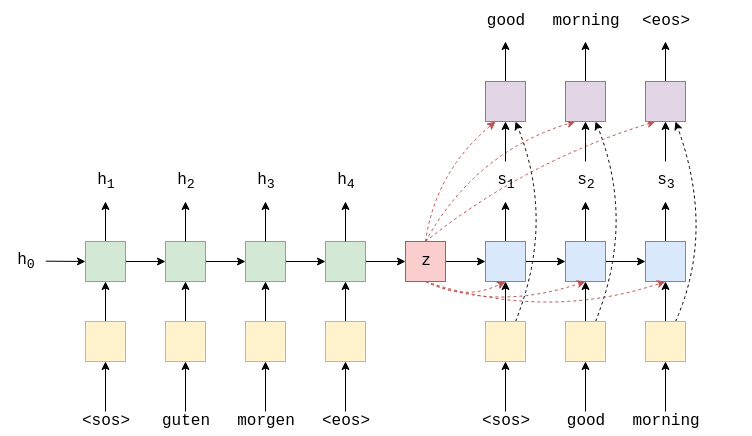

We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it the model on the test set.

In [40]:
model.load_state_dict(torch.load('tut-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.587 | Test PPL:  98.167 |


## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- feed the source sentence into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs and hidden state the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [41]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    #ensure our model is in evaluation mode, which it should always be for inference
    model.eval()

    #tokenize the source sentence if it has not been tokenized (is a string)    
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # numericalize the source sentence    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    #convert it to a tensor and add a batch dimension
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    #feed the source sentence into the encoder
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    #create a list to hold the output sentence, initialized with an <sos> token    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    #create a tensor to hold the attention values
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        #get the input tensor, which should be either <sos> or the last predicted token
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        #feed the input, all encoder outputs and hidden state the decoder        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        #store attention values
        attentions[i] = attention   
        pred_token = output.argmax(1).item()
        
        #add prediction to current output sentence prediction
        trg_indexes.append(pred_token)

        #break if the prediction was an <eos> token
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    #convert the output sentence from indexes to tokens
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    #return the output sentence (with the <sos> token removed) and the attention values over the sequence
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [43]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [44]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'white', 'dog', 'and', 'a', 'a', 'dog', '.', '<eos>']


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

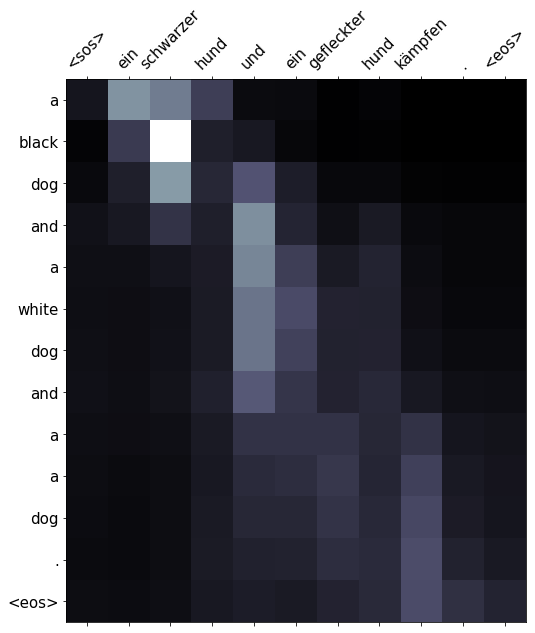

In [45]:
display_attention(src, translation, attention)

In [46]:
example_idx = 100

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'älterer', ',', 'übergewichtiger', 'mann', 'wendet', 'einen', 'pfannkuchen', ',', 'während', 'er', 'frühstück', 'macht', '.']
trg = ['an', 'older', ',', 'overweight', 'man', 'flips', 'a', 'pancake', 'while', 'making', 'breakfast', '.']


predicted trg = ['a', 'young', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', '<unk>', 'of', 'a', '<unk>', '.', '<eos>']


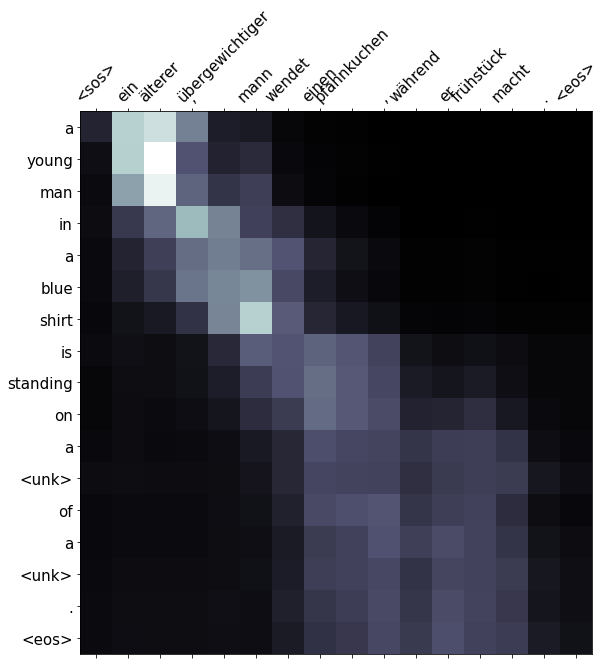

In [47]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [48]:
example_idx = 43

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'schaukelt', 'mit', 'den', 'füßen', 'in', 'der', 'luft', 'in', 'einem', 'wald', '.']
trg = ['a', 'kid', 'swings', 'with', 'his', 'feet', 'up', 'in', 'the', 'air', 'in', 'a', 'forest', '.']


predicted trg = ['a', 'young', 'boy', 'with', 'a', 'in', 'the', 'air', 'in', 'the', 'air', 'in', 'the', 'background', '.', '<eos>']


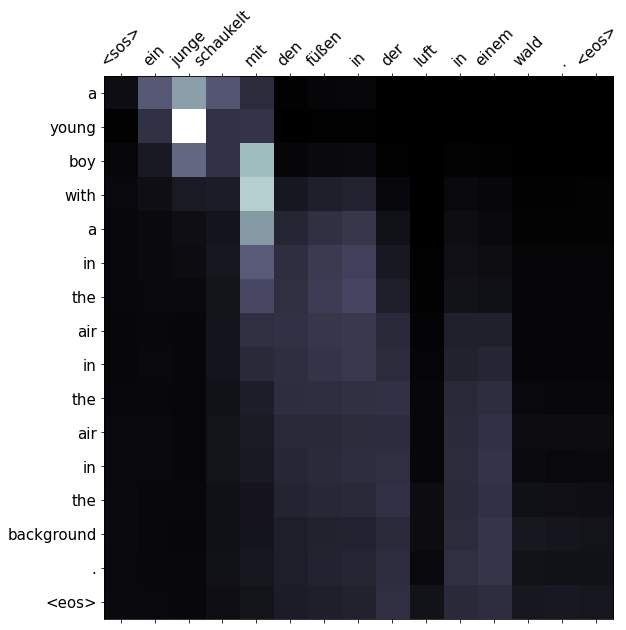

In [49]:

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [50]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

Print BLEU score:

In [51]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 5.77


## Some Important tool/libraries in NLP Applications/Research
- [Hugging face](http://huggingface.co/) 
- [PyTorch Lightning](https://www.pytorchlightning.ai/)
- [Fairseq](https://fairseq.readthedocs.io/en/latest/?badge=latest)
- [OpenNMT](https://opennmt.net/)
- [Weight and Biases](https://wandb.ai/site)
- [The Language Interpretability Tool (LIT)](https://pair-code.github.io/lit/)